In [ ]:
include("load_save.jl")
using XLSX, FASTX, DataFrames, AverageShiftedHistograms, Loess, PyPlot, Printf

In [4]:
R, X, Y, L, F, Y, PY = load_big_dataset("avGFP", val_mode=true);
R1, X1, Y1, L1, MF1, SF1, Y1, PY1 = load_small_dataset("avGFPs", 'B', val_mode=true);
R2, X2, Y2, L2, MF2, SF2, Y2, PY2 = load_small_dataset("avGFPs", 'C', val_mode=true);
R3, X3, Y3, L3, MF3, SF3, Y3, PY3 = load_small_dataset("avGFPs", 'F', val_mode=true);

In [3]:
M = load_dataset_model("avGFP"); # brightness
M1 = load_dataset_model("avGFPs", 'B'); # emission
M2 = load_dataset_model("avGFPs", 'C'); # exciation
M3 = load_dataset_model("avGFPs", 'F'); # brightness

In [5]:
excel_data = DataFrame(XLSX.readtable("Save/avGFP.xlsx", "Sheet1", infer_eltypes=true))
ref_seq = [FASTA.sequence(String, record) for record in open(FASTA.Reader, "Save/avGFP_ref.fasta")][1]
ref_seq = collect(ref_seq)

seq_vector  = Vector{String}()
for mut in excel_data[!, 2]
    seq = deepcopy(ref_seq)
    seq[[65, 72, 77, 203]] .= collect(mut)
    push!(seq_vector, join(seq))
end

In [6]:
data_vector = [[M, L, "avGFP_b"], [M1, L1, "avGFPs_b"], [M2, L2, "avGFPs_c"], [M3, L3, "avGFPs_f"]];
for i in eachindex(data_vector)
    push!(data_vector[i], parallel_predict(data_vector[i][1], data_vector[i][2], seq_vector))
end

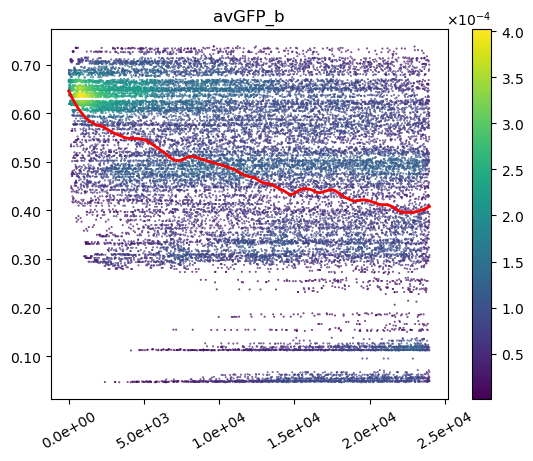

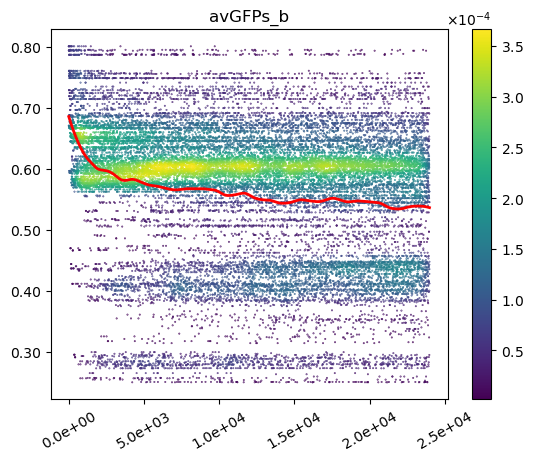

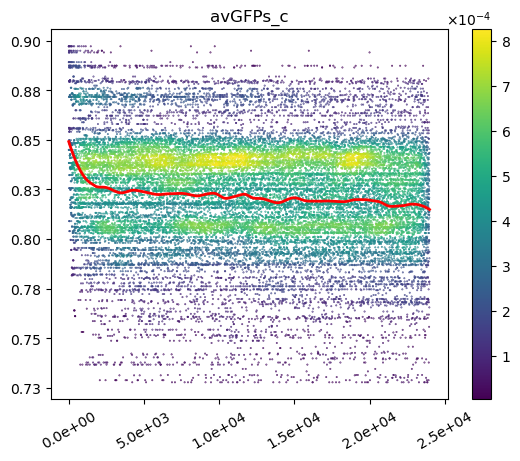

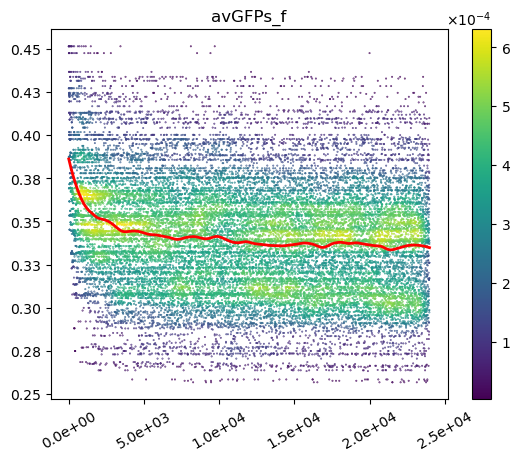

In [9]:
ratio = 0.15
for (ind, data) in enumerate(data_vector)
    m, l, ti, ans = data
    # ans = min_max_norm(ans)
    
    ans = ans[1:floor(Int, ratio*length(ans))]
    xs = 1:length(ans)
    ys = ans

    model = loess(xs, ys; span=0.15)
    us = range(extrema(xs)...; step=0.1)
    vs = Loess.predict(model, us)

    color = Vector{Float64}()
    ke = AverageShiftedHistograms.Kernels.gaussian
    kde = ash(xs, ys, nbin=150, kernelx=ke, kernely=ke)
    for (tru, val) in zip(xs, ys) 
        push!(color, AverageShiftedHistograms.pdf(kde, tru, val))
    end
    sorted_idx = sortperm(color)

    matplotlib.pyplot.rcParams["font.family"] = "Arial"
    fig, ax = subplots()
    ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.1e"))
    ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.2f"))
    xticks(rotation=30)
    scatter(xs[sorted_idx], ys[sorted_idx], c=color[sorted_idx], s=0.15)
    plot(us, vs, linewidth=2, c="red")
    cbar = colorbar()
    cbar.ax.ticklabel_format(useMathText=true, scilimits=(0, 0))
    title(ti)

    savefig("Fig/f3-$ind.tiff", dpi=600, bbox_inches="tight")
    display(gcf())
    close("all")
end